In [10]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [11]:
#undistort funtion
# Function to take undistort the image using the parameters generated from calibration
# pick the calibration data from the calibration_pickle.p file
def Undistort(image):
    d_pickle = pickle.load(open("./calibration_pickle.p","rb"))
    mtx = d_pickle["mtx"]
    dist = d_pickle["dist"] 
    result = cv2.undistort(image, mtx, dist, None, mtx)
    return result

#differention of the image across x and y axis( horizintal and vertical)

def abs_sobel_threshold(image, orientation='x', thresh_min=0, thresh_max=255):
    grayscale = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    if orientation == 'x':
        abs_sobel = np.absolute(cv2.Sobel(grayscale, cv2.CV_64F, 1, 0))  # Absolute x derivative to accentuate lines away from horizontal
    if orientation == 'y':
        abs_sobel = np.absolute(cv2.Sobel(grayscale, cv2.CV_64F, 0, 1))  # Absolute y derivative to accentuate lines away from horizontal
    scaled_sobel =  np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_out = np.zeros_like(scaled_sobel)
    binary_out[(scaled_sobel>=thresh_min)&(scaled_sobel<=thresh_max)]=1
    return binary_out
      

#Colour treshold
#this function should help choose the colour threshold for the pitcures
# HLS and HSV trasform is performed and s , v channel is chosen as the lane visibility is better here

def set_colour_threshold(image, s_thresh , v_thresh ):
    t_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = t_image[:,:,2]
    S_img = np.zeros_like(s_channel)
    S_img[(s_channel >=s_thresh[0]) & (s_channel<=s_thresh[1]) ]=1
    v_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    v_channel = v_image[:,:,2]
    V_img = np.zeros_like(v_channel)
    V_img[(v_channel >=v_thresh[0]) & (v_channel<=v_thresh[1])]=1
    colour_bin = np.zeros_like(s_channel)
    colour_bin[(S_img==1)&(V_img==1)]=1
    return colour_bin

# the perspective transform is performed on the image 
# 4 edges are chosen from the input image and mapped to destination space


def warp(image):
    image_size = (image.shape[1],image.shape[0])
    
    src = np.float32([
        [180,700],
        [600,450],
        [1100,700],
        [720,450]
    ])
    
    dst = np.float32([
        [270,700],
        [270,0],
        [1150,700],
        [1150,0]
    ])
    M = cv2.getPerspectiveTransform(src, dst)
    M_R = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(image, M, image_size, flags=cv2.INTER_LINEAR)
    return warped , M_R

## finds the hostogram , identifing the lane line    

def hist(image):
    bottom_half= image[image.shape[0]//2:,:]
    hist = np.sum(bottom_half,axis=0)
    return hist

# function to identify the lane lines 

def find_lane(warp_image):
    histogram = hist(warp_image)
    out_img = np.dstack((warp_image,warp_image,warp_image))
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
# HYPERPARAMETERS
# Choose the number of sliding windows
    nwindows = 9
# Set the width of the windows +/- margin
    margin = 100
# Set minimum number of pixels found to recenter window
    minpix = 50

# Set height of windows - based on nwindows above and image shape
    window_height = np.int(warp_image.shape[0]//nwindows)
# Identify the x and y positions of all nonzero (i.e. activated) pixels in the image
    nonzero = warp_image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
# Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

# Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    good_left_inds=[]
    good_right_inds=[]

        # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = warp_image.shape[0] - (window+1)*window_height
        win_y_high = warp_image.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2)        
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]        
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass
        
            # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

# function to fit the 2 degree polynomial

def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane(binary_warped)
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]    
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    return out_img ,pts,leftx,lefty,rightx,righty,ploty

def draw_lane(image,pts,inv):    # draw polygon
    zero_img = np.zeros_like(image).astype(np.uint8)
    cv2.fillPoly(zero_img, np.int_([pts]), (0,255, 0))
    warp = cv2.warpPerspective(zero_img, inv, (image.shape[1], image.shape[0]))
    result = cv2.addWeighted(image, 1, warp, 0.4, 0)
    return result
    
def measure_curvature(leftx,lefty,rightx,righty,ploty,image_shape):
    leftnx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightnx = rightx[::-1]  # Reverse to match top-to-bottom in y
    ym_per_pix =  30/700 # meters per pixel in y dimension#
    xm_per_pix = 3.7/950 # meters per pixel in x dimension
    y_eval = np.max(ploty)
    im =image_shape[0]
    car_position = (image_shape[1])/2
# Fit new polynomials to x,y in world space
    left_fit_r = np.polyfit(lefty*ym_per_pix, leftnx*xm_per_pix, 2)
    right_fit_r = np.polyfit(righty*ym_per_pix, rightnx*xm_per_pix, 2)

##### Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = ((1 + (2*left_fit_r[0]*y_eval*ym_per_pix + left_fit_r[1])**2)**1.5) / np.absolute(2*left_fit_r[0])
    right_curverad = ((1 + (2*right_fit_r[0]*y_eval*ym_per_pix + right_fit_r[1])**2)**1.5) / np.absolute(2*right_fit_r[0])
    radius = (left_curverad + right_curverad)/2

    #in pixel space
    left_fit_p = np.polyfit(lefty, leftx, 2)
    right_fit_p = np.polyfit(righty, rightx, 2)
    if left_fit_p is not None and right_fit_p is not None:
        left_lane_pos  = left_fit_p[0]*y_eval**2 + left_fit_p[1]*y_eval + left_fit_p[2]
        right_lane_pos = right_fit_p[0]*y_eval**2 + right_fit_p[1]*y_eval + right_fit_p[2]
    deviation = ((car_position) - ((left_lane_pos+right_lane_pos)/2)) *  xm_per_pix   
    return radius , deviation
    
    
def print_data(image,radius,deviation):
    img = np.copy(image)
    cv2.putText(img, "Radius: {} m".format(int(radius)), (50,80), cv2.FONT_HERSHEY_SIMPLEX, 1, (225,225,225), 2, cv2.LINE_AA)
    cv2.putText(img, "center deviation: {0:.3f} m".format(deviation), (50,130), cv2.FONT_HERSHEY_SIMPLEX, 1, (225,225,225), 2, cv2.LINE_AA)
    return img

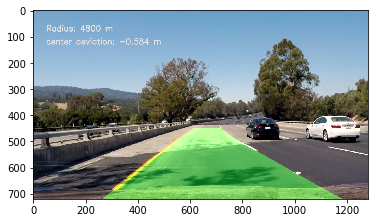

In [12]:
image = cv2.imread('test_images/test4.jpg')
image = image[:,:,::-1]
undist = Undistort(image)
processimage=np.zeros_like(image[:,:,0])
grad_x =abs_sobel_threshold(undist,'x',thresh_min=20, thresh_max=255)
grad_y =abs_sobel_threshold(undist,'y',thresh_min=25, thresh_max=255)
colour_img = set_colour_threshold(image ,s_thresh=(100,255),v_thresh=(50,255) )
processimage[((grad_x==1)&(grad_y==1)|(colour_img==1))] = 255
warped_image, inv = warp(processimage)
poly_image , pts,leftx,lefty,rightx,righty,ploty = fit_polynomial(warped_image)
r,d = measure_curvature(leftx,lefty,rightx,righty,ploty,(image.shape))
img = print_data(image,r,d)
result = draw_lane(img,pts,inv)
plt.imshow(result)





In [13]:
def process_image(image):
    undist = Undistort(image)
    processimage=np.zeros_like(image[:,:,0])
    grad_x =abs_sobel_threshold(undist,'x',thresh_min=20, thresh_max=255)
    grad_y =abs_sobel_threshold(undist,'y',thresh_min=25, thresh_max=255)
    colour_img = set_colour_threshold(image ,s_thresh=(100,255),v_thresh=(50,255) )
    processimage[((grad_x==1)&(grad_y==1)|(colour_img==1))] = 255
    warped_image, inv = warp(processimage)
    poly_image , pts,leftx,lefty,rightx,righty,ploty = fit_polynomial(warped_image)
    r,d = measure_curvature(leftx,lefty,rightx,righty,ploty,(image.shape))
    img = print_data(image,r,d)
    result = draw_lane(img,pts,inv)
    return result

In [ ]:
output = 'test_videos_output/project_video_output.mp4'

#clip2 = VideoFileClip('project_video.mp4').subclip(0,5)
clip2 = VideoFileClip('project_video.mp4')
clip = clip2.fl_image(process_image)
%time clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video test_videos_output/project_video_output.mp4
[MoviePy] Writing video test_videos_output/project_video_output.mp4


 99%|█████████▉| 1254/1261 [06:03<00:02,  3.36it/s]